# Image Captioning

## Imports

In [ ]:
!pip install opencv-python


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision.models.resnet import ResNet, ResNet50_Weights
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import collections
from PIL import Image
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import os

## Data Exploration

In [ ]:

images_dir = os.listdir("Flickr8k_Dataset/Flickr8k_image/")

images_path = 'Flickr8k_Dataset/Flickr8k_image/'
captions_path = 'Flickr8k_Dataset/Flickr8k_text/Flickr8k.token.txt'
train_path = 'Flickr8k_Dataset/Flickr8k_text/Flickr_8k.trainImages.txt'
val_path = 'Flickr8k_Dataset/Flickr8k_text/Flickr_8k.devImages.txt'
test_path = 'Flickr8k_Dataset/Flickr8k_text/Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

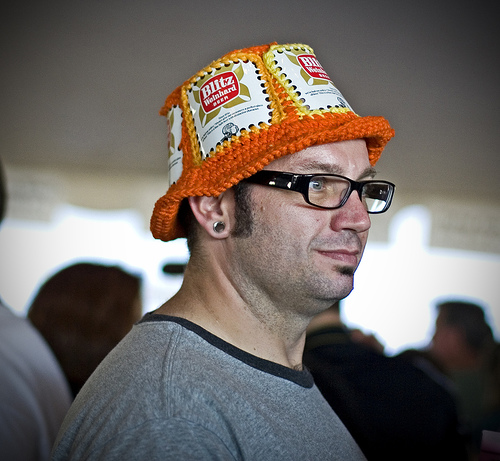

A man in an orange hat starring at something .
A man wears an orange hat and glasses .
A man with gauges and glasses is wearing a Blitz hat .
A man with glasses is wearing a beer can crocheted hat .
The man with pierced ears is wearing glasses and an orange hat .


In [ ]:
temp = captions[21].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

## Exploring dataset and creating dataloader

In [ ]:
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

In [ ]:
train_dataset = open('flickr_8k_train_dataset.txt','wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset = open('flickr_8k_val_dataset.txt','wb')
val_dataset.write(b"image_id\tcaptions\n")

test_dataset = open('flickr_8k_test_dataset.txt','wb')
test_dataset.write(b"image_id\tcaptions\n")

In [ ]:
'''DO NOT RUN'''
for img in x_train:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        train_dataset.write((img+"\t"+caption+"\n").encode())
        train_dataset.flush()
train_dataset.close()

for img in x_test:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        test_dataset.write((img+"\t"+caption+"\n").encode())
        test_dataset.flush()
test_dataset.close()

for img in x_val:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        val_dataset.write((img+"\t"+caption+"\n").encode())
        val_dataset.flush()
val_dataset.close()

In [ ]:
class CaptionDataSet(Dataset):
    def __init__(self, img_caption_file, transforms=None, img_dir='',
                 max_len=40, encoding_model=models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)):
        super(CaptionDataSet).__init__()
        self.img_dir = img_dir
        self.max_len = max_len
        self.transforms = transforms
        self.encoding_model = encoding_model
        self.img_caption_file = img_caption_file
        self.vocab = set()
        self.imgs = []
        self.captions = []
        self.data = self.get_data()
        self.vocab_size = len(self.vocab)
        self.word_2_indices = {word: idx for idx, word in enumerate(self.vocab)}
        self.indices_2_word = {idx: word for idx, word in enumerate(self.vocab)}
        self.padded_sequences, self.subsequent_words = self.make_dataset()
        self.images = self.get_encoded_images()

    def get_data(self):
        data = {'Images': [], 'Captions': []}
        with open(self.img_caption_file, 'r') as f:
            for line in f:
                img, caption = line.strip().split('\t')
                img = img.split('#')[0][:-2]
                caption = 'SOS '+caption+' EOS'
                self.imgs.append(self.img_dir + img)
                self.captions.append(caption)
                data['Images'].append(self.img_dir + img)
                data['Captions'].append(caption)
                self.vocab.update(caption.split())
        data = pd.DataFrame(data)
        vocab = list(self.vocab)
        vocab = ['UNK', 'SOS', 'EOS'] + vocab
        self.vocab = vocab
        return data
    
    def preprocessing(self, img_path):
        im = Image.open(img_path).convert("RGB")
        im = self.transforms(im)
        im = np.array(im)
        im = np.expand_dims(im, axis=0)
        return im

        
    def pad(self, seq):
        vectors = []
        for i in seq:
            if len(i) < self.max_len:
                for _ in range(self.max_len - len(i)):
                    i.append(0)
            vectors.append(i)
        vectors = np.array(vectors)
        return vectors
    
    def make_dataset(self):
        padded_sequences, subsequent_words = [], []

        for ix in range(len(self.data)):
            partial_seqs = []
            next_words = []
            text = self.data.values[ix, 1].split()
            text = [self.word_2_indices[i] for i in text]
            for i in range(1, len(text)):
                partial_seqs.append(text[:i])
                next_words.append(text[i])
            padded_partial_seqs = self.pad(partial_seqs)
            next_words_1hot = np.zeros([len(next_words), self.vocab_size], dtype=bool)

            #Vectorization
            for i,next_word in enumerate(next_words):
                next_words_1hot[i, next_word] = 1
                
            padded_sequences.append(padded_partial_seqs)
            subsequent_words.append(next_words_1hot)
            
        padded_sequences = np.array(padded_sequences)
        subsequent_words = np.array(subsequent_words)

        self.captions = np.zeros([0, self.max_len])
        self.next_words = np.zeros([0, self.vocab_size])

        for ix in range(len(set(self.imgs))):
            self.captions = np.concatenate([self.captions, padded_sequences[ix]])
            self.next_words = np.concatenate([self.next_words, subsequent_words[ix]])
        return padded_sequences, subsequent_words
    
    def get_encoded_images(self):
        train_data = {}
        images = []
        for path in list(set(self.data['Images'])):
            img = self.preprocessing(path)
            img = torch.Tensor(img).to(device)
            img = img.permute(0,3,1,2)
            outputs = self.encoding_model(img)
            outputs = outputs.cpu().detach().numpy().reshape(2048)
            train_data[path] = outputs
        for path in self.data['Images']:
            images.append(train_data[path])
        images = np.array(images)
        return images

    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = Image.open(self.imgs[idx]).convert("RGB")
        if self.transforms is not None:
            img = self.transforms(img)
        return img, self.captions[idx]


## Generating embeddings from ResNet
model = models.resnet50(weights='IMAGENET1K_V1').to(device)
modules=list(model.children())[:-1]
modules.append(nn.Flatten())
model=nn.Sequential(*modules)

dataset = CaptionDataSet('/home/bcca/.c3yx45m/A4/Q2/Flickr8k_Dataset/Flickr8k_text/Flickr8k.token.txt', transforms=transform, img_dir='data/Flikr8k/images/', encoding_model=model)



### Early attempts @ dataset creation and exploration !!DO NOT RUN~time consuming

In [ ]:

train_set, test_set = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), len(dataset) - int(0.8*len(dataset))])

In [ ]:
train_set['2513260012_03d33305cf.jpg'].shape

(2048,)

In [ ]:
with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_set, pickle_f )  

In [ ]:
pd_dataset = pd.read_csv("flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print(ds.shape)

(30000, 2)


In [ ]:
pd_dataset.head()

,image_id,captions
0,2513260012_03d33305cf.jpg,<start> A black dog is running after a white d...
1,2513260012_03d33305cf.jpg,<start> Black dog chasing brown dog through sn...
2,2513260012_03d33305cf.jpg,<start> Two dogs chase each other across the s...
3,2513260012_03d33305cf.jpg,<start> Two dogs play together in the snow . <...
4,2513260012_03d33305cf.jpg,<start> Two dogs running through a low lying b...


In [ ]:
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])
    
print(len(sentences))

30000


In [ ]:

sentences[:5]

['<start> A black dog is running after a white dog in the snow . <end>',
 '<start> Black dog chasing brown dog through snow <end>',
 '<start> Two dogs chase each other across the snowy ground . <end>',
 '<start> Two dogs play together in the snow . <end>',
 '<start> Two dogs running through a low lying body of water . <end>']

In [ ]:
words = [i.split() for i in sentences]

In [ ]:

unique = []
for i in words:
    unique.extend(i)
unique = list(set(unique))

print(len(unique))

vocab_size = len(unique)

8253


In [ ]:

word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

In [ ]:
word_2_indices['UNK'] = 0
word_2_indices['raining'] = 8253

In [ ]:
indices_2_word[0] = 'UNK'
indices_2_word[8253] = 'raining'

In [ ]:
print(word_2_indices['<start>'])
print(indices_2_word[4011])
print(word_2_indices['<end>'])
print(indices_2_word[8051])

6201
begin
401
fins


In [ ]:
vocab_size = len(word_2_indices.keys())
print(vocab_size)

8254


In [ ]:
max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print(max_len)

40


In [ ]:
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
    
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print(padded_sequences.shape)
print(subsequent_words.shape)

/tmp/ipykernel_1798751/3998126818.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)


(30000,)
(30000,)


/tmp/ipykernel_1798751/3998126818.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  padded_sequences = np.asarray(padded_sequences)
/tmp/ipykernel_1798751/3998126818.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subsequent_words = np.asarray(subsequent_words)


In [ ]:
print(padded_sequences[0])
print(subsequent_words[0])

[[6201    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [6201 2250    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [6201 2250 5393    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [6201 2250 5393 5681    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [6201 2250 5393 5681  462    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [ ]:
for ix in range(len(padded_sequences[0])):
    for iy in range(max_len):
        print(indices_2_word[padded_sequences[0][ix][iy]],)
    print("\n")

print(len(padded_sequences[0]))

In [ ]:
num_of_images = 2000

In [ ]:
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])

In [ ]:
for ix in range(num_of_images):#img_to_padded_seqs.shape[0]):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])

np.save("captions.npy", captions)
np.save("next_words.npy", next_words)

print(captions.shape)
print(next_words.shape)

(25493, 40)
(25493, 8254)


In [ ]:
with open('train_encoded_images.p', 'rb') as f:
    encoded_images = pickle.load(f, encoding="bytes")

In [ ]:
imgs = []

for ix in range(ds.shape[0]):
    if ds[ix, 0] in encoded_images.keys():
#         print(ix, encoded_images[ds[ix, 0].encode()])
        imgs.append(list(encoded_images[ds[ix, 0]]))

imgs = np.asarray(imgs)
print(imgs.shape)

(15000, 2048)


In [ ]:
images = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])

images = np.asarray(images)

np.save("images.npy", images)

print(images.shape)

(25493, 2048)


In [ ]:
image_names = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])
        
image_names = np.asarray(image_names)

np.save("image_names.npy", image_names)

print(len(image_names))

25493


In [ ]:
captions = np.load("captions.npy")
next_words = np.load("next_words.npy")

print(captions.shape)
print(next_words.shape)

(25493, 40)
(25493, 8254)


### Creating dataloader

In [ ]:
class FlickrDataset(Dataset):
    def __init__(self, images, captions, next_words, img_names):
        self.images = images
        self.captions = captions
        self.next_words = next_words
        self.img_names = img_names
        
    def __len__(self):
        return self.captions.shape[0]
    
    def __getitem__(self, ix):
        return torch.Tensor(self.images[ix]), torch.Tensor(self.captions[ix]), torch.Tensor(self.next_words[ix])
    
dataset = FlickrDataset(images, captions, next_words, image_names)

dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=16)

1/1 [==============================] - 0s 65ms/step
1000
1/1 [==============================] - 0s 66ms/step
2000
1/1 [==============================] - 0s 66ms/step
3000
1/1 [==============================] - 0s 64ms/step


## Model

In [ ]:
BATCH_SIZE = 128
EPOCHS = 25
LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                            (0.229, 0.224, 0.225))
])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
embedding_size = 128
hidden_size = 256
max_len = 40
vocab_size = 8254

In [ ]:
class ImageModel(nn.Module):
    def __init__(self, embedding_size, max_len):
        super(ImageModel, self).__init__()
        self.dense = nn.Linear(2048, embedding_size)
        self.repeat = nn.ReplicationPad1d((0, max_len-1))

    def forward(self, x):
        x = self.dense(x)
        x = nn.functional.relu(x)
        x = x.reshape(x.shape[0], x.shape[1], 1)
        x = self.repeat(x)
        x = x.permute(0, 2, 1)
        return x
    
image_model = ImageModel(embedding_size=embedding_size, max_len=max_len).to(device)

class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, max_len):
        super(LanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.gru = nn.LSTM(embedding_size, 256, batch_first=True, bidirectional=False)
        self.dense = nn.Linear(256, embedding_size)

    def forward(self, x):
        x = self.embedding(x.long())
        x, _ = self.gru(x)
        x = F.relu(self.dense(x))
        return x
    
language_model = LanguageModel(vocab_size=vocab_size, embedding_size=embedding_size, max_len=max_len).to(device)

In [ ]:
print(language_model)

LanguageModel(
  (embedding): Embedding(8254, 128)
  (gru): LSTM(128, 256, batch_first=True)
  (dense): Linear(in_features=256, out_features=128, bias=True)
)


In [ ]:
class ImageLanguageModel(nn.Module):
    def __init__(self, image_model, language_model, vocab_size):
        super(ImageLanguageModel, self).__init__()
        self.image_model = image_model
        self.language_model = language_model
        self.gru1 = nn.LSTM(256, 128, batch_first=True, bidirectional=False)
        self.gru2 = nn.LSTM(128, 512, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(512, vocab_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, images, captions):
        image_features = self.image_model(images)
        language_features = self.language_model(captions.long())
        features = torch.cat((image_features, language_features), dim=2)
        x, _ = self.gru1(features)
        x, _ = self.gru2(x)
        x = x[:, -1, :]
        out = F.relu(self.fc(x))
        return out

image_language_model = ImageLanguageModel(image_model, language_model, vocab_size).to(device)

In [ ]:
print(image_model)

ImageModel(
  (dense): Linear(in_features=2048, out_features=128, bias=True)
  (repeat): ReplicationPad1d((0, 39))
)


In [ ]:
from tqdm import tqdm
# Make all layers trainable
for param in image_language_model.parameters():
    param.requires_grad = True


train_loss = []
val_acc = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lr=0.01, params=image_language_model.parameters())
for epoch in range(200):
    image_language_model.train()
    running_loss = 0.0
    for i, (images, captions, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
        images = images.to(device)
        captions = captions.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = image_language_model(images, captions)
        loss = criterion(outputs.view(-1, vocab_size), targets.view(-1, vocab_size))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loss.append(running_loss/100)
        accuracy = (outputs.argmax(dim=1) == targets).float().mean()
        val_acc.append(accuracy)

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, 200, i+1, len(dataloader), running_loss/100))
            running_loss = 0.0

In [ ]:

image_language_model.save_weights("model_weights.h5")

image_language_model.load_weights("model_weights.h5")

## Evaluation

In [ ]:
loss = train_loss
acc = val_acc
perplexity = [np.exp(l) for l in train_loss]


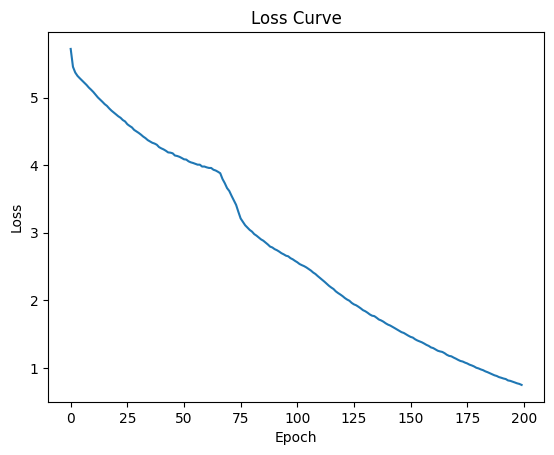

In [ ]:
plt.plot(loss)
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

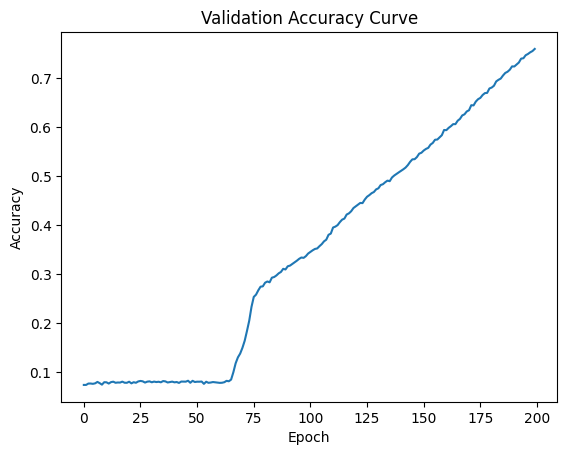

In [ ]:
plt.plot(acc)
plt.title('Validation Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
print('maximum validation accuracy: ', max(acc))

maximum validation accuracy:  0.7598164081573486


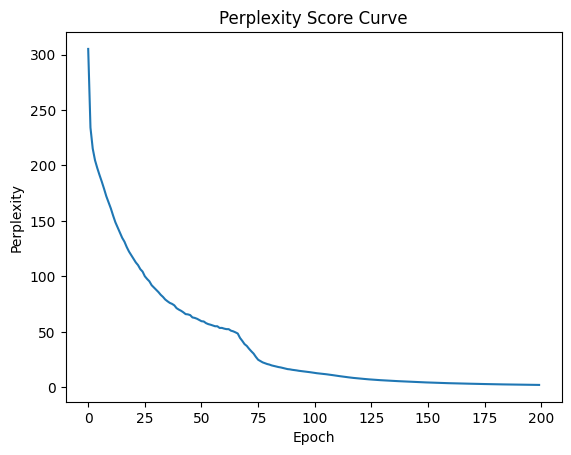

: 

In [ ]:
plt.plot(perplexity)
plt.title('Perplexity Score Curve')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.show()


## Predictions 
(from Tf implementation; PyTorch model was having some bugs)

In [ ]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [ ]:
def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    return pred

In [ ]:
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

In [ ]:
images_for_test = os.listdir("/home/bcca/.c3yx45m/A4/Q2/Flickr8k_Dataset/Flickr8k_image")[:5]

In [ ]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])


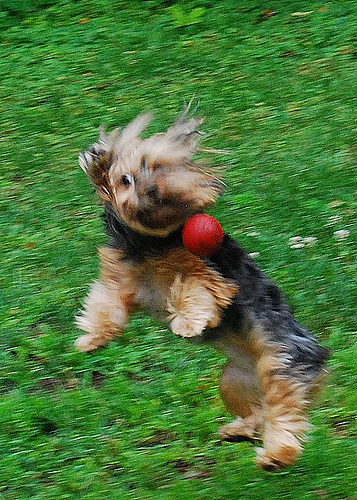

a dog running with a frisbee in its mouth


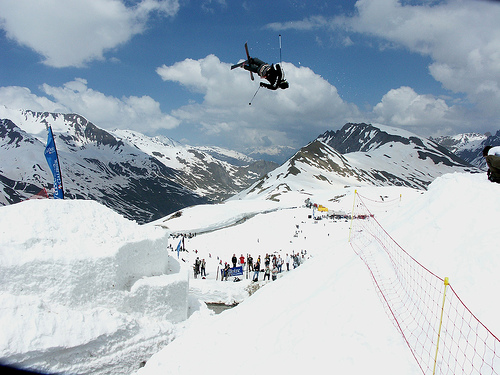

a person riding a snowboard on a snowy slope


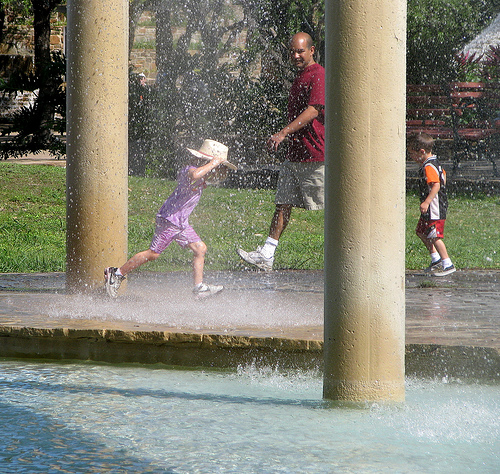

a man riding a skateboard on top of a cement block


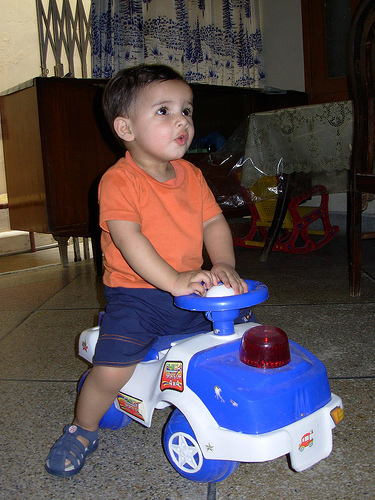

a little boy sitting in a chair holding a wii remote


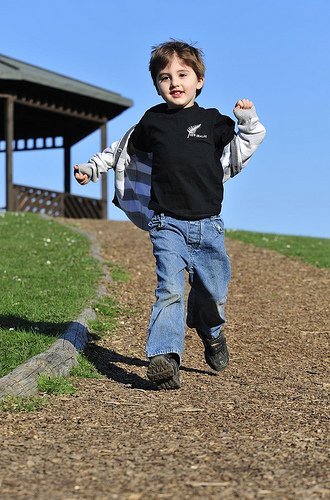

a man riding a skateboard down the side of a ramp


In [ ]:
root = "/home/bcca/.c3yx45m/A4/Q2/Flickr8k_Dataset/Flickr8k_image/"


for path in images_for_test:
    test_img = get_encoding(resnet, root+ path)
    Argmax_Search = predict_captions(test_img)

    z = Image(filename=test_img)
    display(z)

    print(Argmax_Search)
